In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms, models as models
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
data_dir_classification='drive/MyDrive/Colab Notebooks/WasteML/Classification-Learning'
data_dir_category='drive/MyDrive/Colab Notebooks/WasteML/Category-Learning'
classes_classification = ['Inorganic', 'Organic']
classes_category = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
print(classes_classification)
print(classes_category)

Mounted at /content/drive/
['Inorganic', 'Organic']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
from torchvision.datasets import ImageFolder

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset_classification = ImageFolder(data_dir_classification, transform = transformations)
dataset_category = ImageFolder(data_dir_category, transform = transformations)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample_classification(img, label):
    print("Label:", dataset_classification.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

def show_sample_category(img, label):
    print("Label:", dataset_category.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: Inorganic (Class No: 0)


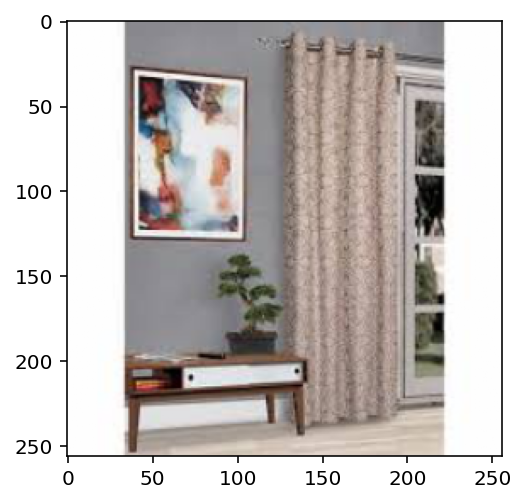

In [ ]:
img, label = dataset_classification[300]
show_sample_classification(img, label)

Label: cardboard (Class No: 0)


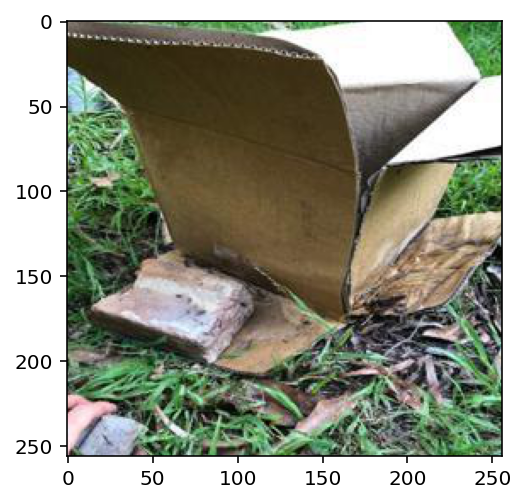

In [ ]:
img, label = dataset_category[12]
show_sample_category(img, label)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
train_ds_classification, val_ds_classification, test_ds_classification = random_split(dataset_classification, [16037, 4009, 5012])
len(train_ds_classification), len(val_ds_classification), len(test_ds_classification)

(16037, 4009, 5012)

In [ ]:
train_ds_category, val_ds_category, test_ds_category = random_split(dataset_category, [11205, 2802, 3502])
len(train_ds_category), len(val_ds_category), len(test_ds_category)

(11205, 2802, 3502)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [ ]:
train_dl_classification = DataLoader(train_ds_classification, batch_size, shuffle = True, num_workers = 0, pin_memory = True)
val_dl_classification = DataLoader(val_ds_classification, batch_size*2, num_workers = 0, pin_memory = True)
test_dl_classification= DataLoader(test_ds_classification, batch_size, shuffle = True, num_workers = 0, pin_memory = True)

In [ ]:
train_dl_category= DataLoader(train_ds_category, batch_size, shuffle = True, num_workers = 0, pin_memory = True)
val_dl_category = DataLoader(val_ds_category, batch_size*2, num_workers = 0, pin_memory = True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

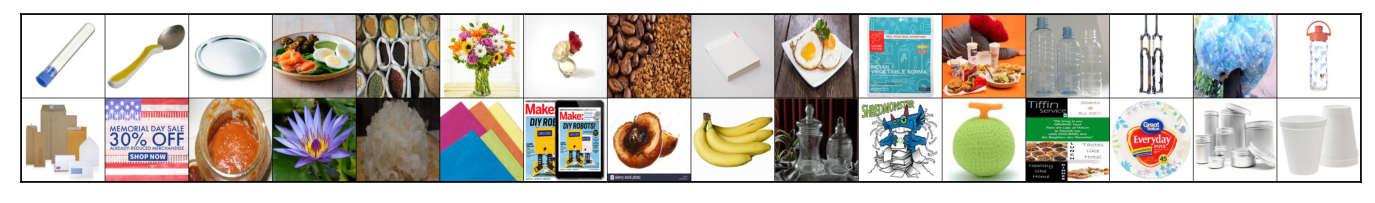

In [ ]:
show_batch(train_dl_classification)

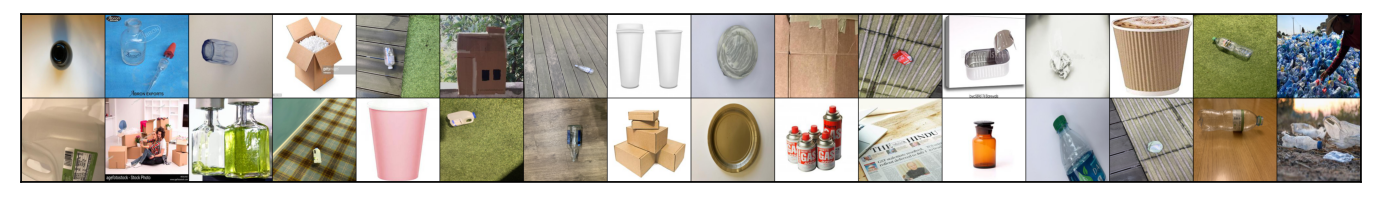

In [ ]:
show_batch(train_dl_category)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageCategoryBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class ResNet_Category(ImageCategoryBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset_category.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model_category = ResNet_Category()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
model_classification = models.densenet121(pretrained=True)
model_classification

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
train_dl_category = DeviceDataLoader(train_dl_category, device)
val_dl_category = DeviceDataLoader(val_dl_category, device)
to_device(model_category, device)

ResNet_Category(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [ ]:

model_classification = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model_classification.parameters():
    param.requires_grad = False
    
model_classification.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 6),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model_classification.classifier.parameters(), lr=0.003)

model_classification.to(device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit_category(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history_category = []
    optimizer_category = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses_category = []
        for batch in train_loader:
            loss_category = model.training_step(batch)
            train_losses_category.append(loss_category)
            loss_category.backward()
            optimizer_category.step()
            optimizer_category.zero_grad()
        # Validation phase
        result_category = evaluate(model, val_loader)
        result_category['train_loss'] = torch.stack(train_losses_category).mean().item()
        model.epoch_end(epoch, result_category)
        history_category.append(result_category)
    return history_category

In [ ]:
model_category = to_device(ResNet_Category(), device)

In [ ]:
# number of epochs to train the model for Classification
n_epochs = 30

train_losses_classification = []
valid_losses_classification = []


valid_loss_min_classification = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss_classification = 0.0
    valid_loss_classification = 0.0
    
    ###################
    # train the model #
    ###################

        
    model_classification.train()
    for data, target in train_dl_classification:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output_classification = model_classification(data)
        # calculate the batch loss
        loss_classification = criterion(output_classification, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss_classification.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss_classification += loss_classification.item()*data.size(0)


   
        
    ######################    
    # validate the model #
    ######################
    model_classification.eval()
    for data, target in val_dl_classification:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output_classification = model_classification(data)
        # calculate the batch loss
        loss_classification = criterion(output_classification, target)
        # update average validation loss 
        valid_loss_classification += loss_classification.item()*data.size(0)
    
    # calculate average losses
    train_loss_classification = train_loss_classification/len(train_dl_classification.sampler)
    valid_loss_classification = valid_loss_classification/len(val_dl_classification.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss for Classification: {:.6f} \tValidation Loss for Classification: {:.6f}'.format(
        epoch, train_loss_classification, valid_loss_classification))
    
    train_losses_classification.append(train_loss_classification)
    valid_losses_classification.append(valid_loss_classification)
    
    # save model if validation loss has decreased
    if valid_loss_classification <= valid_loss_min_classification:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model for Classification...'.format(
        valid_loss_min_classification,
        valid_loss_classification))
        torch.save(model_classification.state_dict(), 'model_waste_classification.pt')
        valid_loss_min_classification = valid_loss_classification


# number of epochs to train the model for Classification
num_epochs = 100
opt_func = torch.optim.Adam
lr = 1e-6
print("Training of Model for Category Learning: ")
history_category = fit_category(num_epochs, lr, model_category, train_dl_category, val_dl_category, opt_func)

Epoch: 1 	Training Loss for Classification: 0.240661 	Validation Loss for Classification: 0.174783
Validation loss decreased (inf --> 0.174783).  Saving model for Classification...
Epoch: 2 	Training Loss for Classification: 0.192922 	Validation Loss for Classification: 0.147031
Validation loss decreased (0.174783 --> 0.147031).  Saving model for Classification...
Epoch: 3 	Training Loss for Classification: 0.181599 	Validation Loss for Classification: 0.129424
Validation loss decreased (0.147031 --> 0.129424).  Saving model for Classification...
Epoch: 4 	Training Loss for Classification: 0.167412 	Validation Loss for Classification: 0.129285
Validation loss decreased (0.129424 --> 0.129285).  Saving model for Classification...
Epoch: 5 	Training Loss for Classification: 0.162530 	Validation Loss for Classification: 0.132754
Epoch: 6 	Training Loss for Classification: 0.147736 	Validation Loss for Classification: 0.126188
Validation loss decreased (0.129285 --> 0.126188).  Saving mode

In [ ]:
model_classification.load_state_dict(torch.load('model_waste_classification.pt'))

<All keys matched successfully>

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

acc_classification = []

model_classification.eval()
# iterate over test data
for data, target in test_dl_classification:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_classification(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    acc_classification.append(correct)          # Calculate accuracy
    # calculate test accuracy for each object class
    for i in range(2):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_dl_classification.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes_classification[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes_classification[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.113215

Test Accuracy of Inorganic: 95% (139/145)
Test Accuracy of Organic: 97% (164/169)

Test Accuracy (Overall): 96% (303/314)


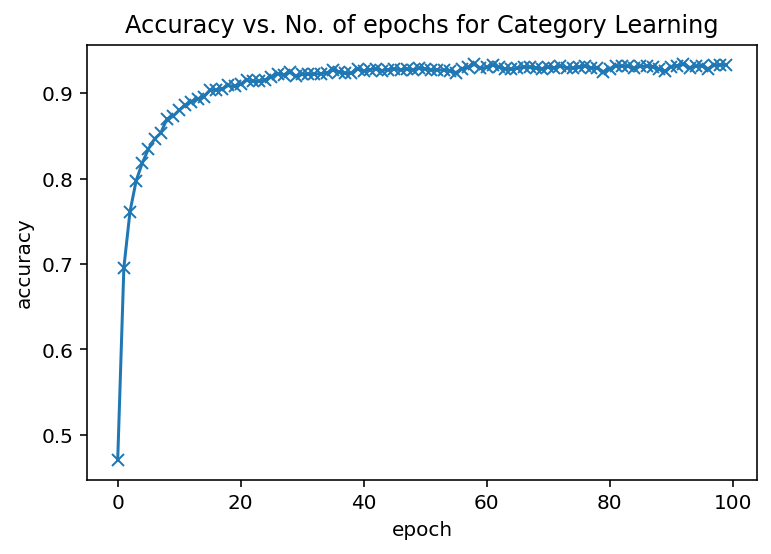

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs for Category Learning');

plot_accuracies(history_category)

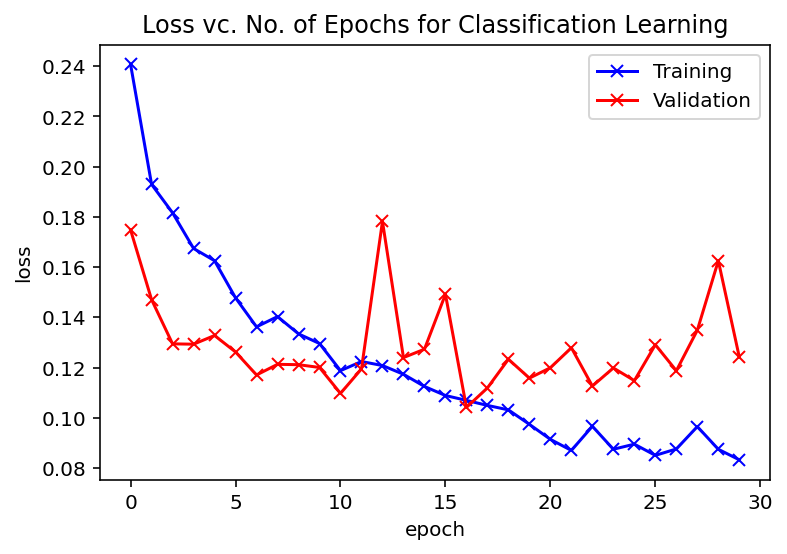

In [ ]:
def plot_losses_classification(tl, vl):
  train_lossses = tl
  val_losses = vl
  plt.plot(train_lossses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vc. No. of Epochs for Classification Learning')

plot_losses_classification(train_losses_classification, valid_losses_classification)

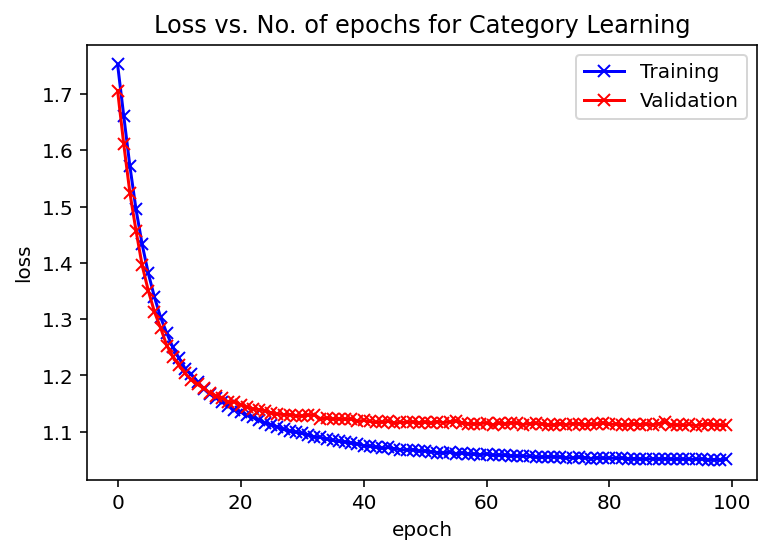

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs for Category Learning');

plot_losses(history_category)

In [ ]:
def predict_image_classification(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset_classification.classes[preds[0].item()]

Label: Organic , Predicted: Organic


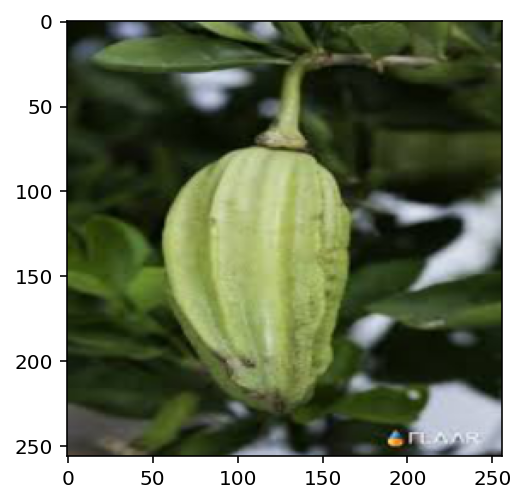

In [ ]:
img, label = test_ds_classification[25]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset_classification.classes[label], ', Predicted:', predict_image_classification(img, model_classification))

Label: Inorganic , Predicted: Inorganic


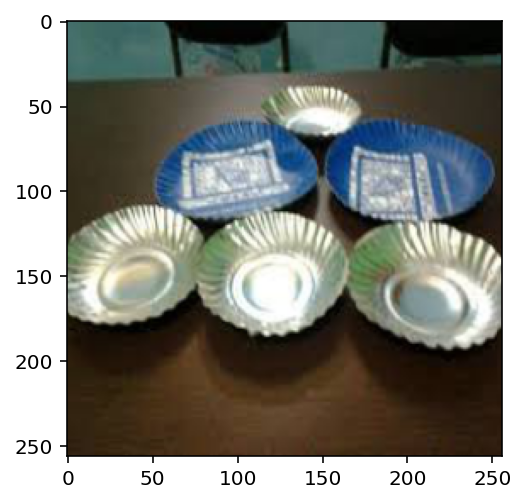

In [ ]:
img, label = test_ds_classification[1500]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset_classification.classes[label], ', Predicted:', predict_image_classification(img, model_classification))

In [ ]:
def predict_image_category(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset_category.classes[preds[0].item()]

Label: plastic , Predicted: plastic


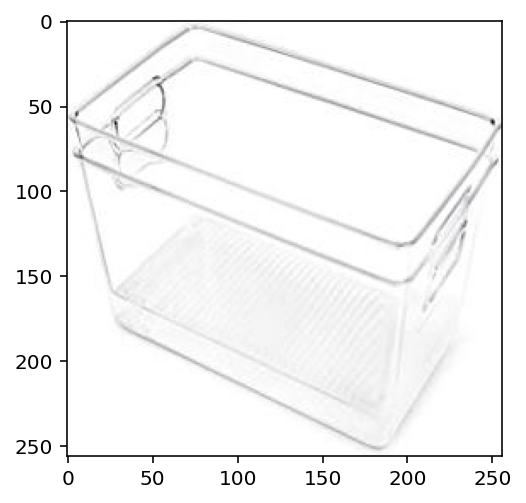

In [ ]:
img, label = test_ds_category[25]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset_category.classes[label], ', Predicted:', predict_image_category(img, model_category))

Label: cardboard , Predicted: cardboard


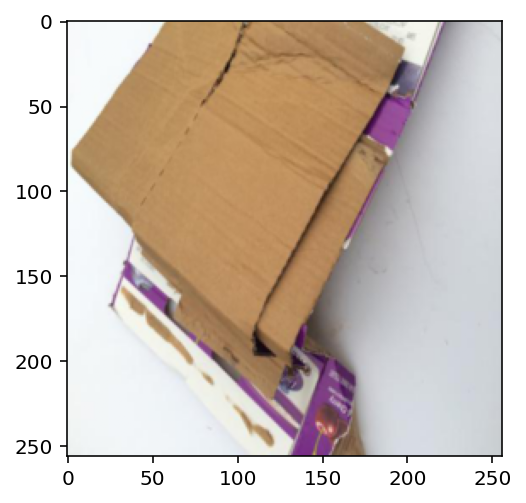

In [ ]:
img, label = test_ds_category[50]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset_category.classes[label], ', Predicted:', predict_image_category(img, model_category))

In [ ]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('drive/MyDrive/Colab Notebooks/' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
   
    check_Classification = predict_image_classification(example_image, model_classification);
    if(check_Classification == 'Organic'):
      print("The image resembles", check_Classification + ".")
    else:
      print("The image resembles", check_Classification + " and this is ", predict_image_category(example_image, model_category),".")

The image resembles Organic.


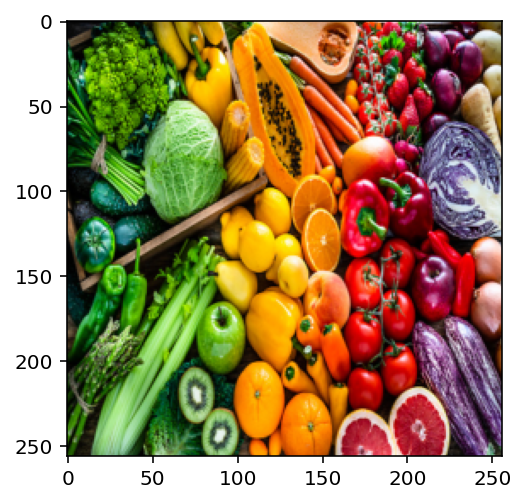

In [ ]:
predict_external_image('vegetables.jpg')

The image resembles Inorganic and this is  metal .


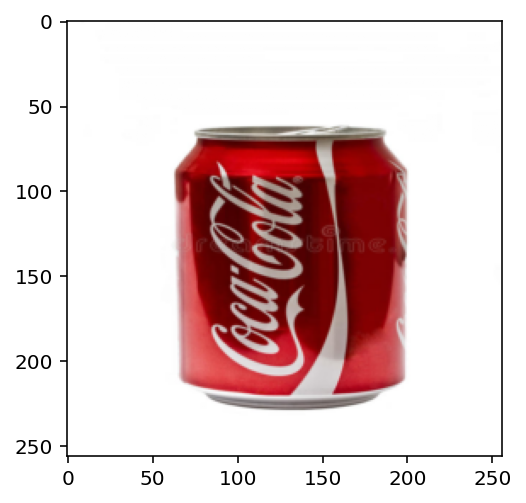

In [ ]:
predict_external_image('coca-cola-can.jpg')